In [6]:
# # aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [7]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import boto3
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from guara.modeling.supervised_modelz import SupervisedModelz

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data

In [8]:
# carregar datasets
df_2015 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Classificao_laudos_2015.xlsx', engine='openpyxl')
df_2015.columns = df_2015.columns.str.lower()
df_2015.rename(columns={'cancer/não cancer':'cancer'}, inplace=True)
df_2015['cancer']=abs(df_2015['cancer']-2)

df_2016 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Classificao_laudos_2016.xlsx', engine='openpyxl')
df_2016.columns = df_2016.columns.str.lower()
df_2016.rename(columns={'cancer/naocancer':'cancer'}, inplace=True)
df_2016['cancer']=abs(df_2016['cancer']-2)

df_2018 =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Classificacao_laudo2018.xlsx', engine='openpyxl')
df_2018.columns = df_2018.columns.str.lower()
df_2018.rename(columns={'(1) câncer |(2) não câncer':'cancer','n_laudo':'laudo'}, inplace=True)
df_2018['cancer']=abs(df_2018['cancer']-2)

In [9]:
# reading output dfs from s3
output_2014 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2014.parquet')
output_2015 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2015.parquet')
output_2016 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2016.parquet')
output_2017 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2017.parquet')
output_2018 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2018.parquet')
output_2019 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2019.parquet')

In [10]:
df_merged_2015 = pd.merge(left=df_2015, right=output_2015, on='laudo', how='inner')
df_merged_2016 = pd.merge(left=df_2016, right=output_2016, on='laudo', how='inner')
df_merged_2018 = pd.merge(left=df_2018, right=output_2018, on='laudo', how='inner')

In [11]:
df_merged_2018

,rgh_x,data,identificador,laudo,texto_diagnostico_resumo,cancer,prediction_score,rgh_y,prediction
0,60,2018-11-14,3024559_1571H18-032592,H18-032592,"[* Carcinoma ductal invasivo (SOE), com focos ...",1,0.992227,60,1
1,434,2018-02-06,2752207_1571H18-003227,H18-003227,[* Adenoma tubular com displasia de baixo grau...,0,0.006452,434,0
2,957,2018-04-16,2813352_1572H18-009825,H18-009825,[* Fragmentos de urotélio sem atipias com disc...,0,0.005709,957,0
3,3034,2018-01-30,2743206_1571H18-002279,H18-002279,"[* Ceratose actínica., * Ceratose actínica., *...",1,0.969400,3034,1
4,3034,2018-10-30,3004785_1576H18-030393,H18-030393,[* Carcinoma epidermoide moderadamente diferen...,1,0.987634,3034,1
...,...,...,...,...,...,...,...,...,...
21792,99047004,2018-02-24,2768392_1571H18-004932,H18-004932,[* Hiperplasia de glândulas de Brunner.],0,0.006346,99047004,0
21793,99047004,2018-03-01,2773209_1571H18-005486,H18-005486,[* Mucosa colônica sem particularidades histol...,0,0.008524,99047004,0
21794,99047306,2018-12-04,3042660_1571H18-034400,H18-034400,"[* Tecido prostático benigno., * Tecido prostá...",1,0.990785,99047306,1
21795,99047560,2018-12-13,3052402_1571H18-035518,H18-035518,[* Adenoma tubular com displasia de baixo grau...,1,0.284329,99047560,0


# Modelagem

In [12]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


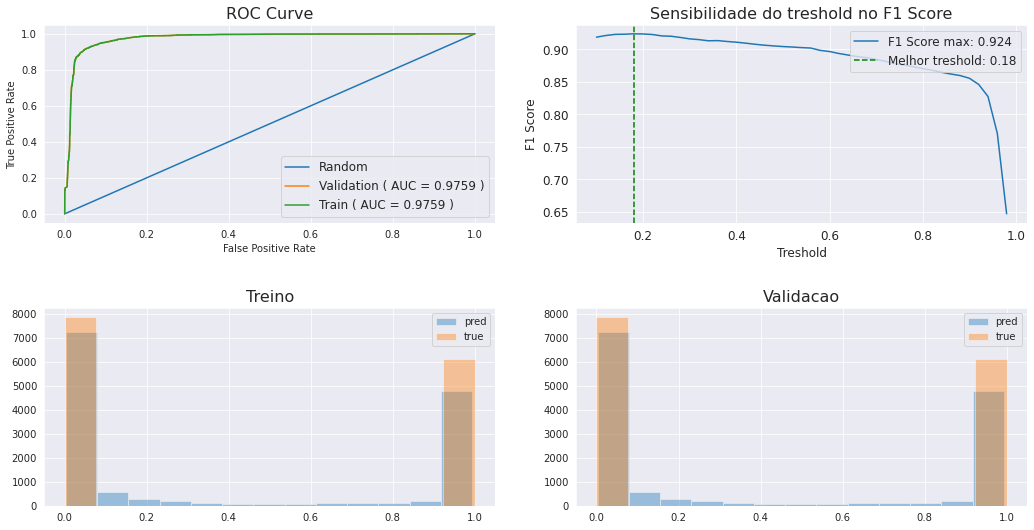

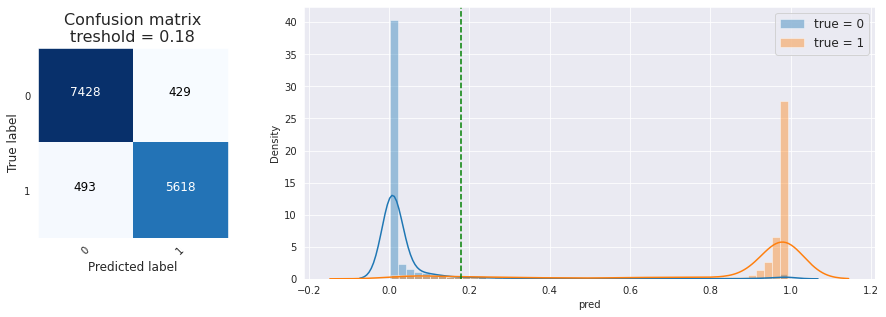


              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7857
           1       0.93      0.92      0.92      6111

    accuracy                           0.93     13968
   macro avg       0.93      0.93      0.93     13968
weighted avg       0.93      0.93      0.93     13968



In [13]:
md.evaluation_plots(
    df_merged_2015['cancer'].values, 
    np.array(df_merged_2015['prediction_score'].values), 
    df_merged_2015['cancer'].values, 
    np.array(df_merged_2015['prediction_score'].values)
    )

false_negative_list = np.where( (df_merged_2015['prediction'] == 0) & (df_merged_2015['cancer'] ==1))

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


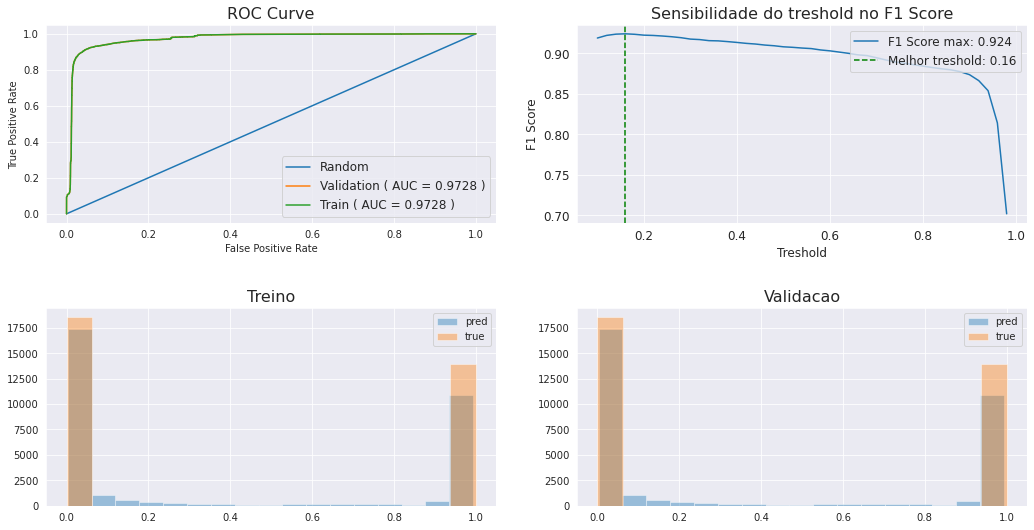

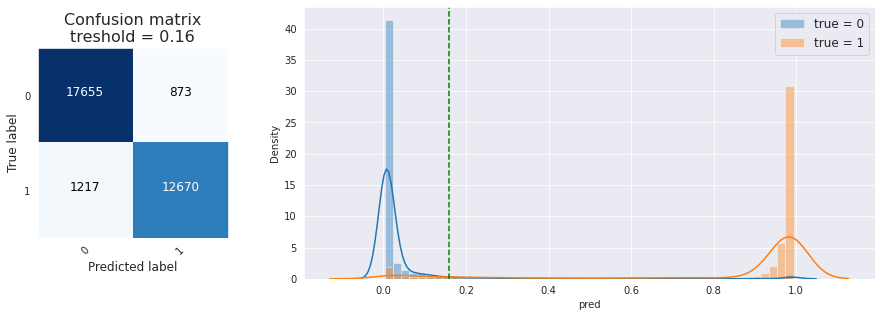


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     18528
           1       0.94      0.91      0.92     13887

    accuracy                           0.94     32415
   macro avg       0.94      0.93      0.93     32415
weighted avg       0.94      0.94      0.94     32415



In [14]:
md.evaluation_plots(
    df_merged_2016['cancer'].values, 
    np.array(df_merged_2016['prediction_score'].values), 
    df_merged_2016['cancer'].values, 
    np.array(df_merged_2016['prediction_score'].values)
    )

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


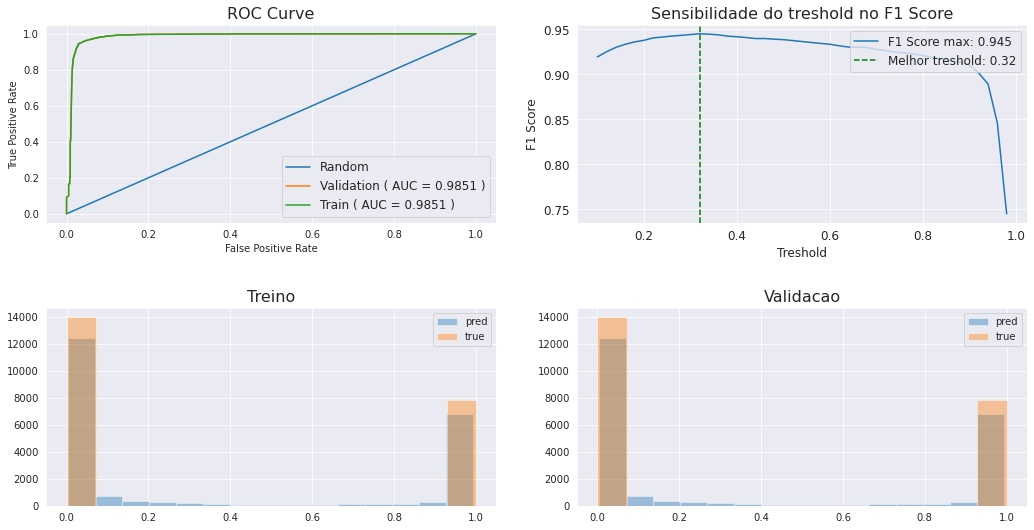

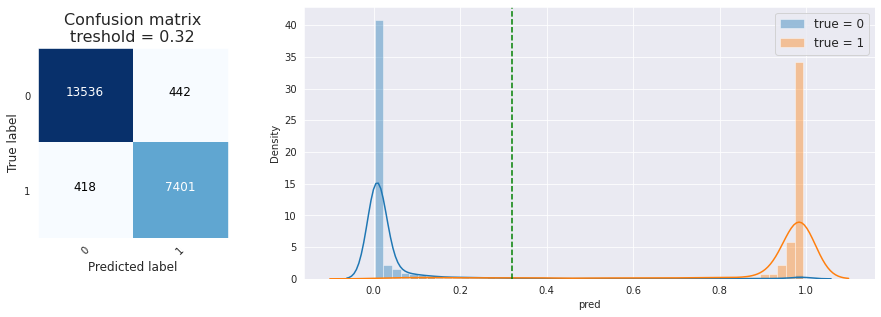


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     13978
           1       0.94      0.95      0.95      7819

    accuracy                           0.96     21797
   macro avg       0.96      0.96      0.96     21797
weighted avg       0.96      0.96      0.96     21797



In [15]:
md.evaluation_plots(
    df_merged_2018['cancer'].values, 
    np.array(df_merged_2018['prediction_score'].values), 
    df_merged_2018['cancer'].values, 
    np.array(df_merged_2018['prediction_score'].values)
    )

In [16]:
reference_list = np.where(df_merged_2018['prediction_score'] >= 0.1)
df_merged_2018['cancer_2'] = 0
df_merged_2018['cancer_2'].iloc[reference_list[0]] = 1
df_merged_2018


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,rgh_x,data,identificador,laudo,texto_diagnostico_resumo,cancer,prediction_score,rgh_y,prediction,cancer_2
0,60,2018-11-14,3024559_1571H18-032592,H18-032592,"[* Carcinoma ductal invasivo (SOE), com focos ...",1,0.992227,60,1,1
1,434,2018-02-06,2752207_1571H18-003227,H18-003227,[* Adenoma tubular com displasia de baixo grau...,0,0.006452,434,0,0
2,957,2018-04-16,2813352_1572H18-009825,H18-009825,[* Fragmentos de urotélio sem atipias com disc...,0,0.005709,957,0,0
3,3034,2018-01-30,2743206_1571H18-002279,H18-002279,"[* Ceratose actínica., * Ceratose actínica., *...",1,0.969400,3034,1,1
4,3034,2018-10-30,3004785_1576H18-030393,H18-030393,[* Carcinoma epidermoide moderadamente diferen...,1,0.987634,3034,1,1
...,...,...,...,...,...,...,...,...,...,...
21792,99047004,2018-02-24,2768392_1571H18-004932,H18-004932,[* Hiperplasia de glândulas de Brunner.],0,0.006346,99047004,0,0
21793,99047004,2018-03-01,2773209_1571H18-005486,H18-005486,[* Mucosa colônica sem particularidades histol...,0,0.008524,99047004,0,0
21794,99047306,2018-12-04,3042660_1571H18-034400,H18-034400,"[* Tecido prostático benigno., * Tecido prostá...",1,0.990785,99047306,1,1
21795,99047560,2018-12-13,3052402_1571H18-035518,H18-035518,[* Adenoma tubular com displasia de baixo grau...,1,0.284329,99047560,0,1


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


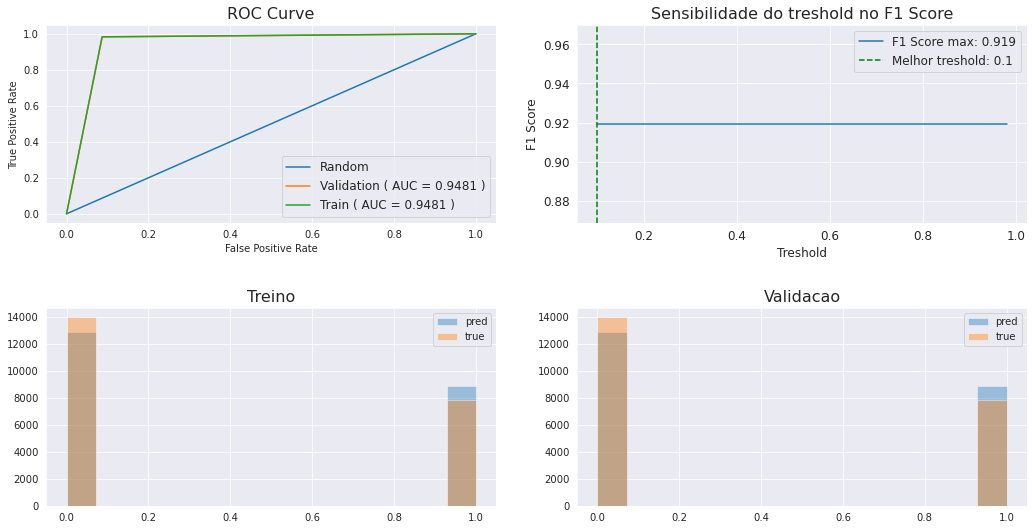

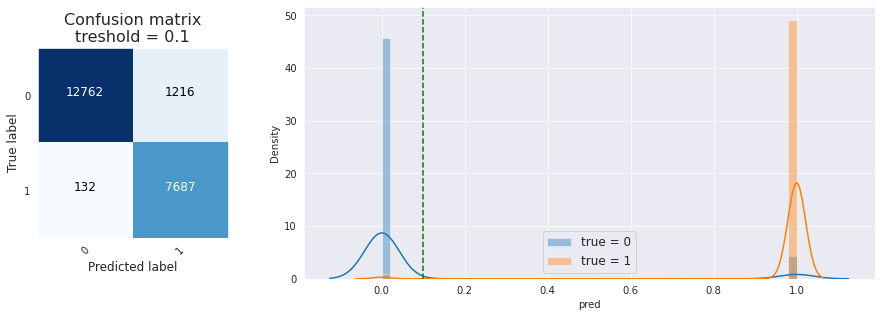


              precision    recall  f1-score   support

           0       0.99      0.91      0.95     13978
           1       0.86      0.98      0.92      7819

    accuracy                           0.94     21797
   macro avg       0.93      0.95      0.93     21797
weighted avg       0.94      0.94      0.94     21797



In [17]:
md.evaluation_plots(
    df_merged_2018['cancer'].values, 
    np.array(df_merged_2018['cancer_2'].values), 
    df_merged_2018['cancer'].values, 
    np.array(df_merged_2018['cancer_2'].values)
    )

In [18]:
print('2015: ', len(df_merged_2015.index))
print('2016: ', len(df_merged_2016.index))
print('2018: ', len(df_merged_2018.index))

2015:  13968
2016:  32415
2018:  21797


## Treshold original

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


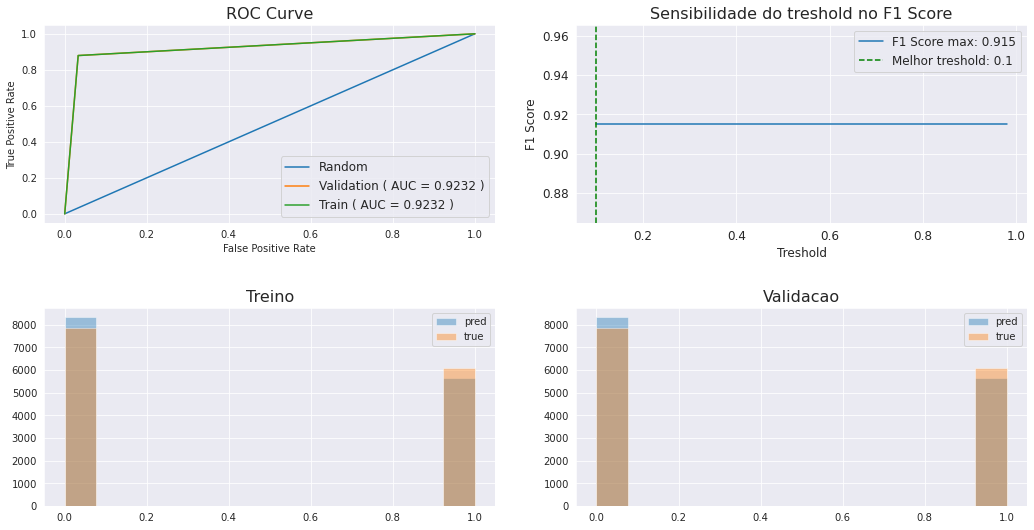

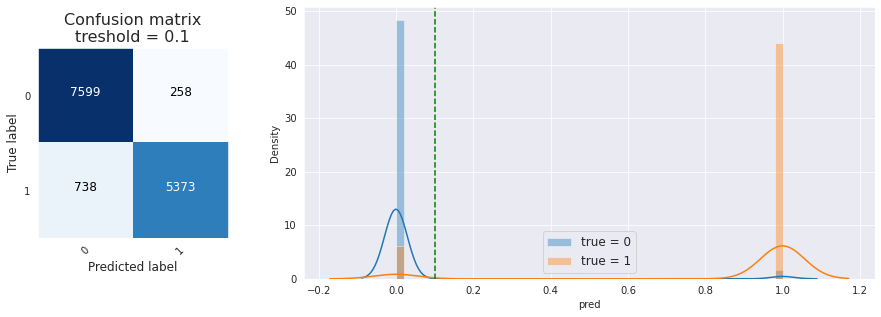


              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7857
           1       0.95      0.88      0.92      6111

    accuracy                           0.93     13968
   macro avg       0.93      0.92      0.93     13968
weighted avg       0.93      0.93      0.93     13968



In [19]:
md.evaluation_plots(
    df_merged_2015['cancer'].values, 
    np.array(df_merged_2015['prediction'].values), 
    df_merged_2015['cancer'].values, 
    np.array(df_merged_2015['prediction'].values)
    )

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


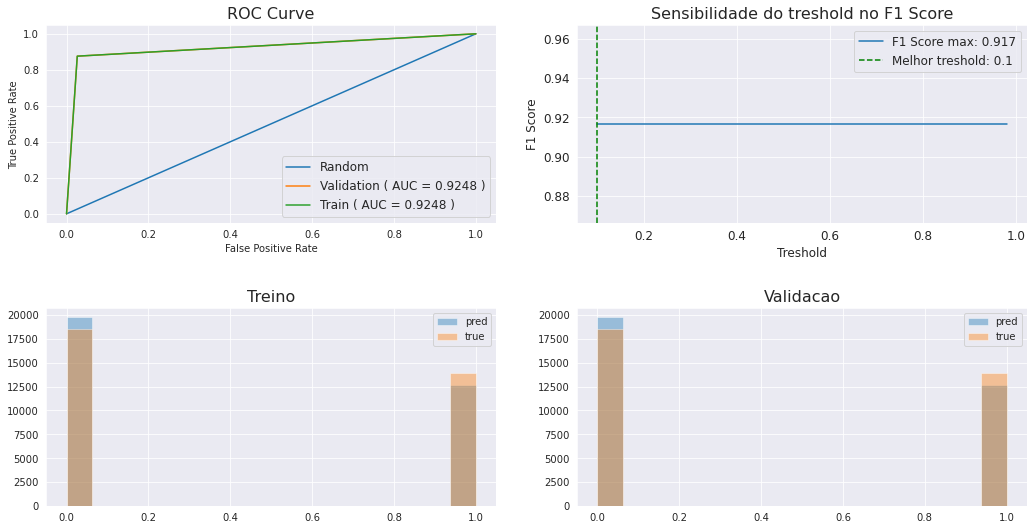

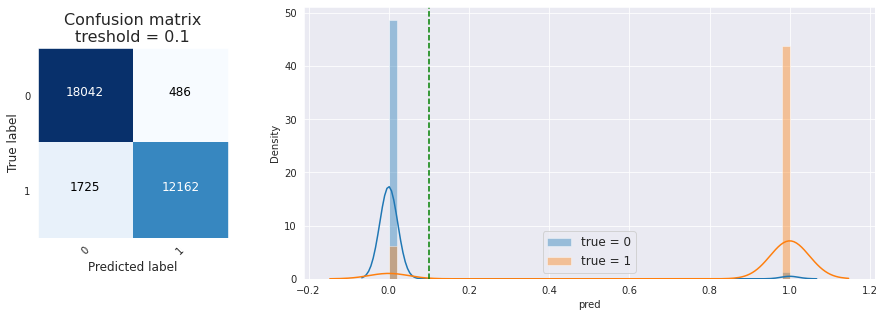


              precision    recall  f1-score   support

           0       0.91      0.97      0.94     18528
           1       0.96      0.88      0.92     13887

    accuracy                           0.93     32415
   macro avg       0.94      0.92      0.93     32415
weighted avg       0.93      0.93      0.93     32415



In [20]:
md.evaluation_plots(
    df_merged_2016['cancer'].values, 
    np.array(df_merged_2016['prediction'].values), 
    df_merged_2016['cancer'].values, 
    np.array(df_merged_2016['prediction'].values)
    )

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


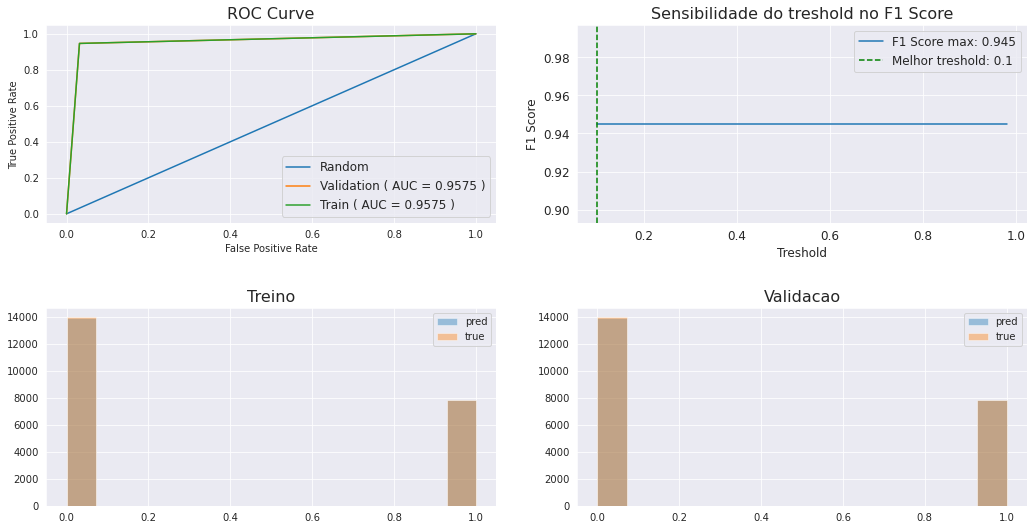

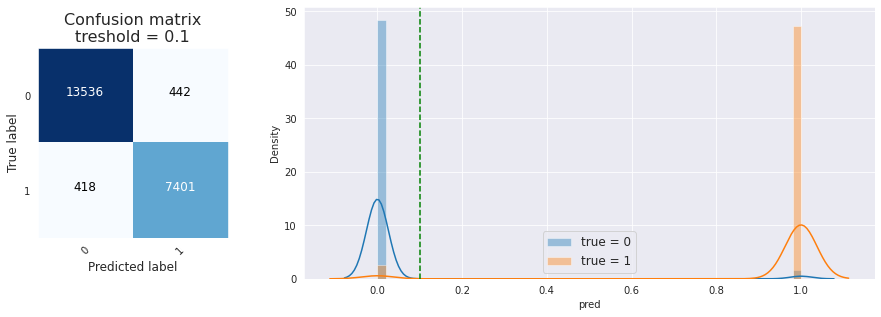


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     13978
           1       0.94      0.95      0.95      7819

    accuracy                           0.96     21797
   macro avg       0.96      0.96      0.96     21797
weighted avg       0.96      0.96      0.96     21797



In [21]:
md.evaluation_plots(
    df_merged_2018['cancer'].values, 
    np.array(df_merged_2018['prediction'].values), 
    df_merged_2018['cancer'].values, 
    np.array(df_merged_2018['prediction'].values)
    )